In [1]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error    
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import tensorflow as tf
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import RandomizedSearchCV

## Load the Data

In [2]:
#we define col names as there are no col names in the dataset file
index= ["engine", "cycle"]
setting = [f"op_setting_{i}" for i in range(1, 4)]
sensor = [
    "Fan inlet temperature (◦R)",
    "LPC outlet temperature (◦R)",
    "HPC outlet temperature (◦R)",
    "LPT outlet temperature (◦R)",
    "Fan inlet Pressure (psia)",
    "Bypass-duct pressure (psia)",
    "HPC outlet pressure (psia)",
    "Physical fan speed (rpm)",
    "Physical core speed (rpm)",
    "Engine pressure ratio (P50/P2)",
    "HPC outlet Static pressure (psia)",
    "Ratio of fuel flow to Ps30 (pps/psia)",
    "Corrected fan speed (rpm)",
    "Corrected core speed (rpm)",
    "Bypass Ratio",
    "Burner fuel-air ratio",
    "Bleed Enthalpy",
    "Required fan speed",
    "Required fan conversion speed",
    "High-pressure turbines Cool air flow",
    "Low-pressure turbines Cool air flow",
]
col_names = index + setting + sensor 
train = pd.read_csv("../../data/raw/train_FD001.txt",sep="\s+", header=None, names = col_names) #separate by whitespace, the + is for one or more spaces
test  = pd.read_csv("../../data/raw/test_FD001.txt",sep="\s+", header=None, names = col_names)
rul = pd.read_csv("../../data/raw/RUL_FD001.txt", sep="\s+", header=None, names=['RUL'])


<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:29: SyntaxWarning: invalid escape sequence '\s'
<>:30: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:29: SyntaxWarning: invalid escape sequence '\s'
<>:30: SyntaxWarning: invalid escape sequence '\s'
C:\Users\halah\AppData\Local\Temp\ipykernel_22476\3751112546.py:28: SyntaxWarning: invalid escape sequence '\s'
  train = pd.read_csv("../../data/raw/train_FD001.txt",sep="\s+", header=None, names = col_names) #separate by whitespace, the + is for one or more spaces
C:\Users\halah\AppData\Local\Temp\ipykernel_22476\3751112546.py:29: SyntaxWarning: invalid escape sequence '\s'
  test  = pd.read_csv("../../data/raw/test_FD001.txt",sep="\s+", header=None, names = col_names)
C:\Users\halah\AppData\Local\Temp\ipykernel_22476\3751112546.py:30: SyntaxWarning: invalid escape sequence '\s'
  rul = pd.read_csv("../../data/raw/RUL_FD001.txt", sep="\s+", header=None, names=['RUL'])


In [3]:
train.head()

,engine,cycle,op_setting_1,op_setting_2,op_setting_3,Fan inlet temperature (◦R),LPC outlet temperature (◦R),HPC outlet temperature (◦R),LPT outlet temperature (◦R),Fan inlet Pressure (psia),...,Ratio of fuel flow to Ps30 (pps/psia),Corrected fan speed (rpm),Corrected core speed (rpm),Bypass Ratio,Burner fuel-air ratio,Bleed Enthalpy,Required fan speed,Required fan conversion speed,High-pressure turbines Cool air flow,Low-pressure turbines Cool air flow
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [ ]:
test.head()

In [ ]:
train.info()

In [ ]:
train.shape

In [ ]:
test.shape

In [ ]:
rul.shape

In [ ]:
train.isna().sum()

In [ ]:
test.isna().sum()

In [ ]:
train.duplicated().sum()

In [ ]:
test.duplicated().sum()

In [ ]:
print("Number of engines in train dataset:", train['engine'].nunique())

In [ ]:
train.describe().T

In [3]:
#From the description of the dataframe we see some columns who seem to be constant (same min and max values) these wont help us so it is safe to drop them
constant_cols = [col for col in train.columns if train[col].nunique() == 1]

print("Columns with constant values:" , constant_cols)
train.drop(constant_cols, axis=1, inplace=True, errors='ignore')
test.drop(constant_cols, axis=1, inplace=True, errors='ignore')

Columns with constant values: ['op_setting_3', 'Fan inlet temperature (◦R)', 'Fan inlet Pressure (psia)', 'Engine pressure ratio (P50/P2)', 'Burner fuel-air ratio', 'Required fan speed', 'Required fan conversion speed']


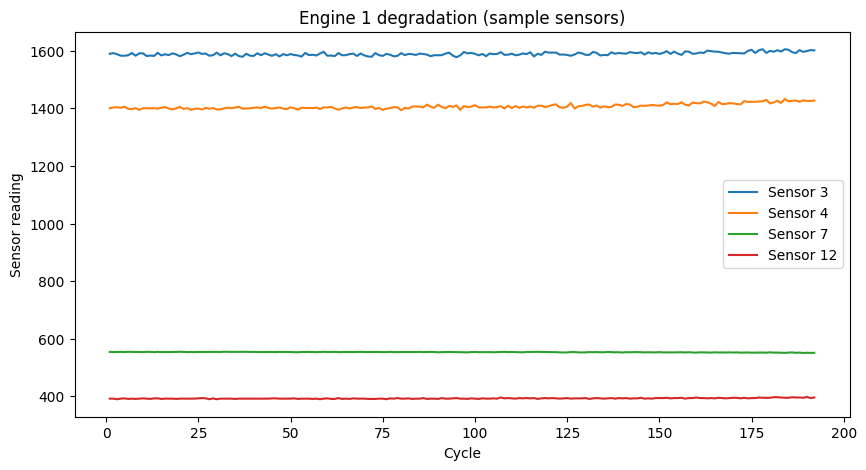

In [4]:
engine1 = train[train['engine']==1]
plt.figure(figsize=(10,5))
plt.plot(engine1['cycle'], engine1['HPC outlet temperature (◦R)'], label='Sensor 3')
plt.plot(engine1['cycle'], engine1['LPT outlet temperature (◦R)'], label='Sensor 4')
plt.plot(engine1['cycle'], engine1['HPC outlet pressure (psia)'], label='Sensor 7')
plt.plot(engine1['cycle'], engine1['Bleed Enthalpy'], label='Sensor 12')
plt.xlabel("Cycle")
plt.ylabel("Sensor reading")
plt.title("Engine 1 degradation (sample sensors)")
plt.legend()
plt.show()

In [ ]:
train.shape

In [ ]:
test.shape

In [5]:

#identifies max cycle for each engine
train['max_cycle'] = train.groupby('engine')['cycle'].transform('max')
#calculates RUL to each cycle 
train['RUL'] = train['max_cycle'] - train['cycle']
#remove max_cycle col as it is no longer needed
train = train.drop('max_cycle', axis=1)
train

,engine,cycle,op_setting_1,op_setting_2,LPC outlet temperature (◦R),HPC outlet temperature (◦R),LPT outlet temperature (◦R),Bypass-duct pressure (psia),HPC outlet pressure (psia),Physical fan speed (rpm),Physical core speed (rpm),HPC outlet Static pressure (psia),Ratio of fuel flow to Ps30 (pps/psia),Corrected fan speed (rpm),Corrected core speed (rpm),Bypass Ratio,Bleed Enthalpy,High-pressure turbines Cool air flow,Low-pressure turbines Cool air flow,RUL
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,643.49,1597.98,1428.63,21.61,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,643.54,1604.50,1433.58,21.61,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594,3
20628,100,198,0.0004,0.0000,643.42,1602.46,1428.18,21.61,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,643.23,1605.26,1426.53,21.61,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640,1



Prepare the test set with RUL labels

In [6]:
#load true RUL values from RUL_FD001.txt
rul_values= rul['RUL'].values

#find the last cycle (max_cycle) for each engine in the test set
test['max_cycle'] = test.groupby('engine')['cycle'].transform('max')

#we create a new dataframe test_rul to facilitate the merge operation
#it contains each engine, its max_cycle and the corresponding true RUL value
test_rul = pd.DataFrame({"engine": test['engine'].unique(), "max_cycle": test.groupby('engine')['cycle'].max().values, "true_RUL": rul_values})

#merge this mapping back to the test set
test= test.merge(test_rul, on=['engine', 'max_cycle'], how='left')
test['RUL'] = test['true_RUL'] + (test['max_cycle'] - test['cycle']) #this computation gives the RUL for each cycle in the test set (decreases linearly)
test= test.drop(columns=['max_cycle', 'true_RUL'])
test


,engine,cycle,op_setting_1,op_setting_2,LPC outlet temperature (◦R),HPC outlet temperature (◦R),LPT outlet temperature (◦R),Bypass-duct pressure (psia),HPC outlet pressure (psia),Physical fan speed (rpm),Physical core speed (rpm),HPC outlet Static pressure (psia),Ratio of fuel flow to Ps30 (pps/psia),Corrected fan speed (rpm),Corrected core speed (rpm),Bypass Ratio,Bleed Enthalpy,High-pressure turbines Cool air flow,Low-pressure turbines Cool air flow,RUL
0,1,1,0.0023,0.0003,643.02,1585.29,1398.21,21.61,553.90,2388.04,9050.17,47.20,521.72,2388.03,8125.55,8.4052,392,38.86,23.3735,142
1,1,2,-0.0027,-0.0003,641.71,1588.45,1395.42,21.61,554.85,2388.01,9054.42,47.50,522.16,2388.06,8139.62,8.3803,393,39.02,23.3916,141
2,1,3,0.0003,0.0001,642.46,1586.94,1401.34,21.61,554.11,2388.05,9056.96,47.50,521.97,2388.03,8130.10,8.4441,393,39.08,23.4166,140
3,1,4,0.0042,0.0000,642.44,1584.12,1406.42,21.61,554.07,2388.03,9045.29,47.28,521.38,2388.05,8132.90,8.3917,391,39.00,23.3737,139
4,1,5,0.0014,0.0000,642.51,1587.19,1401.92,21.61,554.16,2388.01,9044.55,47.31,522.15,2388.03,8129.54,8.4031,390,38.99,23.4130,138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,643.24,1599.45,1415.79,21.61,553.41,2388.02,9142.37,47.69,520.69,2388.00,8213.28,8.4715,394,38.65,23.1974,24
13092,100,195,-0.0011,-0.0001,643.22,1595.69,1422.05,21.61,553.22,2388.05,9140.68,47.60,521.05,2388.09,8210.85,8.4512,395,38.57,23.2771,23
13093,100,196,-0.0006,-0.0003,643.44,1593.15,1406.82,21.61,553.04,2388.11,9146.81,47.57,521.18,2388.04,8217.24,8.4569,395,38.62,23.2051,22
13094,100,197,-0.0038,0.0001,643.26,1594.99,1419.36,21.61,553.37,2388.07,9148.85,47.61,521.33,2388.08,8220.48,8.4711,395,38.66,23.2699,21


## Exploratory Plots

In [ ]:
plt.hist(train['RUL'], bins=50)
plt.xlabel("RUL")
plt.ylabel("Frequency")
plt.title("Distribution of RUL in training set")
plt.show()

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(train.drop(columns=['engine','cycle','RUL']).corr(), cmap="coolwarm")
plt.title("Sensor correlation heatmap")
plt.show()

## Milestone 2:

### Simple Feature engineering

In [7]:
scaler = MinMaxScaler()
sensor_cols = [c for c in train.columns if c not in ['engine','cycle','RUL','op_setting_1','op_setting_2']]

train[sensor_cols] = scaler.fit_transform(train[sensor_cols])
test[sensor_cols] = scaler.transform(test[sensor_cols])

### Time-series Analysis

rolling mean with window = 3 (look back 3 cycles each time), smoother and shows actual trends
Rolling standard deviation (std) → measures variability

If it’s high, the engine is unstable

Rolling min/max → captures recent extremes

Rolling sum → cumulative signal in the last N cycles

In [8]:

useful_sensors = [col for col in sensor_cols if col not in constant_cols]
print("Useful sensors:", useful_sensors)


Useful sensors: ['LPC outlet temperature (◦R)', 'HPC outlet temperature (◦R)', 'LPT outlet temperature (◦R)', 'Bypass-duct pressure (psia)', 'HPC outlet pressure (psia)', 'Physical fan speed (rpm)', 'Physical core speed (rpm)', 'HPC outlet Static pressure (psia)', 'Ratio of fuel flow to Ps30 (pps/psia)', 'Corrected fan speed (rpm)', 'Corrected core speed (rpm)', 'Bypass Ratio', 'Bleed Enthalpy', 'High-pressure turbines Cool air flow', 'Low-pressure turbines Cool air flow']


In [9]:
#short term trends
for col in useful_sensors:
    train[col+'_avg5'] = train.groupby('engine')[col].rolling(window=5, min_periods=1).mean().reset_index(0,drop=True)
    test[col+'_avg5'] = test.groupby('engine')[col].rolling(window=5, min_periods=1).mean().reset_index(0,drop=True)

In [10]:
for col in useful_sensors:
    train[col+'_std5'] = train.groupby('engine')[col].rolling(window=5, min_periods=1).std().reset_index(0,drop=True)
    test[col+'_std5'] = test.groupby('engine')[col].rolling(window=5, min_periods=1).std().reset_index(0,drop=True)

In [11]:
#long term trends
for col in useful_sensors:  
    train[col+'_avg20'] = train.groupby('engine')[col].rolling(window=20, min_periods=1).mean().reset_index(0,drop=True)
    test[col+'_avg20'] = test.groupby('engine')[col].rolling(window=20, min_periods=1).mean().reset_index(0,drop=True)

In [12]:
#delta features see how fast things change
for col in useful_sensors:
    train[col+'_diff'] = train.groupby('engine')[col].diff().fillna(0)
    test[col+'_diff'] = test.groupby('engine')[col].diff().fillna(0)

In [13]:
train['cycle_norm'] = train['cycle'] / train.groupby('engine')['cycle'].transform('max')
test['cycle_norm']  = test['cycle'] / test.groupby('engine')['cycle'].transform('max')

Features so far: 

- Rolling means (5, 20 cycles)

- Rolling std (5 cycles)

- Diff features (rate of change)

- Cycle normalization


In [ ]:

engine_id = 1
sensor = useful_sensors[0] 

unit_df = train[train['engine'] == engine_id]

plt.figure(figsize=(12,6))
plt.plot(unit_df['cycle'], unit_df[sensor], label='Raw', alpha=0.6)
plt.plot(unit_df['cycle'], unit_df[sensor+'_avg5'], label='Rolling Avg (5)', linewidth=2)
plt.plot(unit_df['cycle'], unit_df[sensor+'_avg20'], label='Rolling Avg (20)', linewidth=2)
plt.fill_between(unit_df['cycle'],
                 unit_df[sensor+'_avg5'] - unit_df[sensor+'_std5'],
                 unit_df[sensor+'_avg5'] + unit_df[sensor+'_std5'],
                 color='gray', alpha=0.2, label='±1 Std (5)')
plt.xlabel("Cycle")
plt.ylabel("Sensor Value")
plt.title(f"{sensor} - Raw vs Rolling Features (Engine {engine_id})")
plt.legend()
plt.show()


Degradation trends of all useful sensors across engines

For each sensor, i plotted its 20-cycle rolling average (_avg20) against Remaining Useful Life (RUL) for every 10th engine

RUL decreases from left to right, approaching failure at RUL = 0.

In [ ]:
n = len(useful_sensors)
rows = (n // 3)
fig, axes = plt.subplots(rows, 3, figsize=(15, rows*4))
axes = axes.flatten()

for i, sensor in enumerate(useful_sensors):
    for engine_id in sorted(train['engine'].unique()):
        if engine_id % 10 == 0:
            engine_df = train[train['engine'] == engine_id]
            axes[i].plot(engine_df['RUL'], engine_df[sensor+'_avg20'], alpha=0.6, label=f"Engine {engine_id}")
    axes[i].set_title(sensor)
    axes[i].set_xlim(250, 0)
    axes[i].set_xlabel("Remaining Useful Life (RUL)")
    axes[i].set_ylabel(sensor + "_avg20")
    axes[i].legend(fontsize=6, loc="upper left") 

plt.tight_layout()
plt.show()


Produces same results but separately 

In [ ]:
def plot_sensor_trend(df, sensor_col):
    plt.figure(figsize=(8,6))

    for engine_id in sorted(df['engine'].unique()):
        if engine_id % 10 == 0:
            engine_df = df[df['engine'] == engine_id]
            plt.plot(engine_df['RUL'], engine_df[sensor_col+'_avg20'], label=f'Engine {engine_id}')

    plt.xlim(250, 0)  
    plt.xticks(np.arange(0, 300, 25))
    plt.xlabel("Remaining Useful Life (RUL)")
    plt.ylabel(sensor_col + "_avg20")
    plt.title(f"{sensor_col} (20-cycle rolling mean) across engines")
    plt.legend()
    plt.show()


In [ ]:
for sensor in useful_sensors:
    plot_sensor_trend(train, sensor)



Sensors that exhibit clear downward or upward trends as RUL approaches zero are more informative for Remaining Useful Life prediction. Conversely, sensors that remain flat or noisy across engines are less useful and may be excluded from the final feature set

Top sensors most correlated with Remaining Useful Life (RUL)

This approach reduces clutter while still capturing representative degradation patterns across the fleet

Likely strong candidates for predictive modeling

In [14]:

corrs = train[useful_sensors + ['RUL']].corr()['RUL'].drop('RUL').abs()
top_sensors = corrs.sort_values(ascending=False).head(7).index.tolist()
print("Top sensors correlated with RUL:", top_sensors)


Top sensors correlated with RUL: ['HPC outlet Static pressure (psia)', 'LPT outlet temperature (◦R)', 'Ratio of fuel flow to Ps30 (pps/psia)', 'HPC outlet pressure (psia)', 'Bypass Ratio', 'Low-pressure turbines Cool air flow', 'High-pressure turbines Cool air flow']


In [ ]:

n = len(top_sensors)
rows = (n // 3) + 1 
fig, axes = plt.subplots(rows, 3, figsize=(15, rows*4))
axes = axes.flatten()

for i, sensor in enumerate(top_sensors):
    for engine_id in sorted(train['engine'].unique()):
        if engine_id % 10 == 0:  
            engine_df = train[train['engine'] == engine_id]
            axes[i].plot(engine_df['RUL'], engine_df[sensor+'_avg20'], alpha=0.6)
    axes[i].set_title(f"{sensor} (rolling avg20)")
    axes[i].set_xlim(250, 0)

for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


## Milestone 3:

### 1st workflow:

correlation filtering --> random forest regressor / xgboost  --> evaluation

Correlation filtering removes redundancy

In [15]:
print("Features before correlation filtering:", train.shape)
X = train.drop(columns=['engine','cycle','RUL'])
y = train['RUL']


corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
X_corr_filtered = X.drop(columns=to_drop)


print("Remaining features after correlation filtering:", X_corr_filtered.shape)


Features before correlation filtering: (20631, 81)
Remaining features after correlation filtering: (20631, 59)


In [16]:
X_corr_filtered.isna().sum()[X_corr_filtered.isna().sum() > 0]

LPC outlet temperature (◦R)_std5              100
HPC outlet temperature (◦R)_std5              100
LPT outlet temperature (◦R)_std5              100
Bypass-duct pressure (psia)_std5              100
HPC outlet pressure (psia)_std5               100
Physical fan speed (rpm)_std5                 100
Physical core speed (rpm)_std5                100
HPC outlet Static pressure (psia)_std5        100
Ratio of fuel flow to Ps30 (pps/psia)_std5    100
Corrected fan speed (rpm)_std5                100
Corrected core speed (rpm)_std5               100
Bypass Ratio_std5                             100
Bleed Enthalpy_std5                           100
High-pressure turbines Cool air flow_std5     100
Low-pressure turbines Cool air flow_std5      100
dtype: int64

_std5 features created with rolling std need previous rows, so early ones are NaN, Each engine contributes 4 missing values, totaling ~100

In [17]:

combined = pd.concat([X_corr_filtered, y], axis=1).dropna()
X_corr_filtered = combined.drop(columns=['RUL'])
y = combined['RUL'] # we update y to match the filtered X to avoid misalignment due to dropped rows


### 2nd workflow



corr filtering --> pca --> modeling --> evaluation

Original features: 59
Reduced features: 21


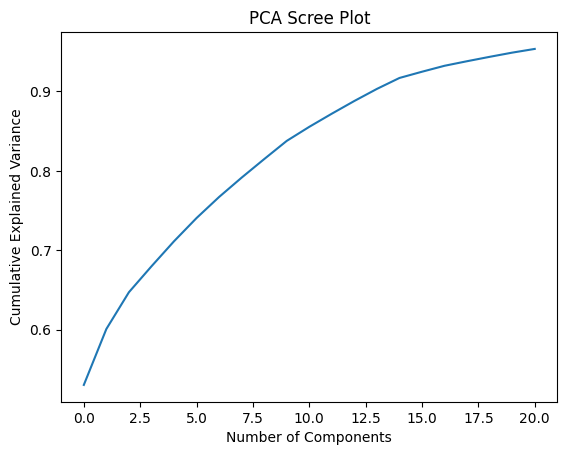

In [15]:

pca = PCA(n_components=0.95)  
X_pca = pca.fit_transform(X_corr_filtered)

print("Original features:", X_corr_filtered.shape[1])
print("Reduced features:", X_pca.shape[1])

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Scree Plot")
plt.show()

In [19]:
y = combined['RUL']
X_train, X_val, y_train, y_val = train_test_split(
    X_pca, y, test_size=0.2, random_state=42
)

NameError: name 'X_pca' is not defined

In [18]:
xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50
)

xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

y_pred = xgb_model.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("XGBoost (Correlation Filtered Features)")
print("RMSE:", rmse)
print("MAE:", mae)
print("R2:", r2)

XGBoost (Correlation Filtered Features)
RMSE: 27.940974554979846
MAE: 19.42732048034668
R2: 0.8280348181724548


In [18]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("Random Forest (Correlation Filtered Features)")
print("RMSE:", rmse)
print("MAE:", mae)
print("R2:", r2)

Random Forest (Correlation Filtered Features)
RMSE: 28.421945390248233
MAE: 19.795517409301194
R2: 0.8220635045793298


### 3rd workflow

correlation filtering --> modeling --> optimization --> evaluation

In [15]:
print("Features before correlation filtering:", train.shape)
X = train.drop(columns=['engine','cycle','RUL'])

corr_matrix = X.corr().abs()

upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print("Dropping these correlated features:", to_drop)

X_corr_filtered = X.drop(columns=to_drop)
print("Remaining features after correlation filtering:", X_corr_filtered.shape)

Features before correlation filtering: (20631, 81)
Dropping these correlated features: ['Corrected core speed (rpm)', 'Physical core speed (rpm)_avg5', 'HPC outlet Static pressure (psia)_avg5', 'Ratio of fuel flow to Ps30 (pps/psia)_avg5', 'Corrected fan speed (rpm)_avg5', 'Corrected core speed (rpm)_avg5', 'LPC outlet temperature (◦R)_avg20', 'LPT outlet temperature (◦R)_avg20', 'HPC outlet pressure (psia)_avg20', 'Physical fan speed (rpm)_avg20', 'Physical core speed (rpm)_avg20', 'HPC outlet Static pressure (psia)_avg20', 'Ratio of fuel flow to Ps30 (pps/psia)_avg20', 'Corrected fan speed (rpm)_avg20', 'Corrected core speed (rpm)_avg20', 'Bypass Ratio_avg20', 'Bleed Enthalpy_avg20', 'High-pressure turbines Cool air flow_avg20', 'Low-pressure turbines Cool air flow_avg20']
Remaining features after correlation filtering: (20631, 59)


In [16]:
y = train['RUL']

X_train, X_val, y_train, y_val = train_test_split(
    X_corr_filtered, y, test_size=0.2, random_state=42
)

In [17]:
param_dist = {
    'n_estimators': [100, 200, 400, 600],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,   
    cv=3,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=2
)

random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)

best_rf = random_search.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}


In [18]:
y_pred = best_rf.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print("Optimized RF RMSE:", rmse)
print("Optimized RF R²:", r2)

Optimized RF RMSE: 27.168081760856918
Optimized RF R²: 0.8384465386555389
